Import libs

In [1]:
from __future__ import print_function
from __future__ import division
from math import atan2, cos, sin, sqrt, pi


from os import listdir
import numpy as np

import random as rd
from random import randint
from mahotas import features
from sklearn.decomposition import PCA
import math
import cv2

Function definitionen

In [2]:
def invert_image(img):
	return (255-img)

def add_images(img1, img2):
	temp = invert_image(img1) + invert_image(img2)
	return invert_image(temp)

def add_images4(img1, img2, img3, img4):
	temp = invert_image(img1) + invert_image(img2) + invert_image(img3) + invert_image(img4)
	return invert_image(temp)

def translate(img, x, y):
	rows, cols = img.shape

	M = np.float32([[1,0,x], [0,1,y]])
	img = cv2.warpAffine(img, M, (cols,rows), borderMode = cv2.BORDER_REPLICATE)

	return img

def rotate(img, winkel):
	rows, cols = img.shape

	# Argumente: Center, Angle, Scale
	M = cv2.getRotationMatrix2D((cols/2,rows/2),winkel,1)
	img = cv2.warpAffine(img, M, (cols,rows), borderMode = cv2.BORDER_REPLICATE)

	return img


# Generate Scene
def generateScene():
    line_styles = ["dreieck", "ellipse", "gerade", "rechteck"]
    orientierung = ["links", "oben", "rechts", "unten"]
    path0 = ["", "", "", ""]
    path1 = ["", "", "", ""]

    for num in range(4):
        path0[num] = "Kanten/" + "kante_" + orientierung[num] + "_" + line_styles[randint(0, 3)] + ".png"

    for num in range(4):
        path1[num] = "Kanten/" + "kante_" + orientierung[num] + "_" + line_styles[randint(0, 3)] + ".png"

    path1[1] = path0[3]

    img0 = []
    img1 = []

    for num in range(4):
        img0.append(cv2.imread(path0[num], 0))
        img1.append(cv2.imread(path1[num], 0))

    img1[1] = translate(img1[1], 0, -100)

    obj0 = add_images4(img0[0], img0[1], img0[2], img0[3])
    obj1 = add_images4(img1[0], img1[1], img1[2], img1[3])

    obj1 = translate(obj1, 0, 100)

    return add_images(obj0,obj1)


# Flächenschwerpunkt berechnen
def calcCentroid(img):
    moments = cv2.moments(img, False)

    cX = float(moments["m10"] / moments["m00"])
    cY = float(moments["m01"] / moments["m00"])

    return [cX, cY]


def fillContour(img):
    	# Threshold.
	# Set values equal to or above 220 to 0.
	# Set values below 220 to 255.

	th, im_th = cv2.threshold(img, 220, 255, cv2.THRESH_BINARY_INV);

	# Copy the thresholded image.
	im_floodfill = im_th.copy()

	# Mask used to flood filling.
	# Notice the size needs to be 2 pixels than the image.
	h, w = im_th.shape[:2]
	mask = np.zeros((h+2, w+2), np.uint8)

	# Floodfill from point (0, 0)
	cv2.floodFill(im_floodfill, mask, (0,0), 255);

	# Invert floodfilled image
	im_floodfill_inv = cv2.bitwise_not(im_floodfill)

	# Combine the two images to get the foreground.
	img_out = im_th | im_floodfill_inv

	return invert_image(img_out)

def pca(img):
    
	# Convert image to binary
	_, bw = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

	contours, _ = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

	# PCA for everything
	contour_size = 0

	for i, contour in enumerate(contours):
		area = cv2.contourArea(contour)
		# Ignore contours that are too small or too large
		if area < 1e2 or 1e5 < area:
			continue

		contour_size += len(contour)

	all_data_pts = np.empty((contour_size, 2), dtype=np.float64)


	k = 0

	for i, contour in enumerate(contours):

		area = cv2.contourArea(contour)
		# Ignore contours that are too small or too large
		if area < 1e2 or 1e5 < area:
			continue

		sz = len(contour)
		data_pts = np.empty((sz, 2), dtype=np.float64)

		# cv2.drawContours(scene, contours, i, (0, 255, 0), 3)

		for i in range(data_pts.shape[0]):
			data_pts[i,0] = contour[i,0,0]
			data_pts[i,1] = contour[i,0,1]

			all_data_pts[i+k,0] = contour[i,0,0]
			all_data_pts[i+k,1] = contour[i,0,1]

		k += len(contour)

	# import sys
	# np.set_printoptions(threshold=sys.maxsize)
	# print("{}".format(all_data_pts))

	# Perform PCA analysis
	mean = np.empty((0))
	mean, eigenvectors, eigenvalues = cv2.PCACompute2(all_data_pts, mean)

	rows, cols = img.shape
	count = 0
	for y in range(rows):
		for x in range(cols):
			if bw[y, x] <= 50:
				count += 1

	a = np.empty((count, 2), dtype=np.float64)

	cc = 0
	for y in range(rows):
		for x in range(cols):
			if bw[y, x] <= 50:
				a[cc, 0] = x
				a[cc, 1] = y
				cc += 1

	# PCA mit sklearn
	pca = PCA(n_components=2)
	pca.fit(a)

	eigenvectors = pca.components_
	eigenvalues = pca.explained_variance_

	eigenvector_p1 = [eigenvectors[0,0], eigenvectors[0,1]]
	img_vector = [img, eigenvector_p1]

	return img_vector

def angle(v1, v2):
    ang1 = np.arctan2(*v1[::-1])
    ang2 = np.arctan2(*v2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

def substraction(img1, img2, img1CentroidCoordinate, img2CentroidCoordinate):
	img1 = translate(img1, -img1CentroidCoordinate[0]+300, -img1CentroidCoordinate[1]+400)
	img2 = translate(img2, -img2CentroidCoordinate[0]+300, -img2CentroidCoordinate[1]+400)
	subImg = cv2.subtract(invert_image(img1), invert_image(img2))
	return invert_image(subImg)

def identical_check(image1, image2):
    return image1.shape == image2.shape and not(np.bitwise_xor(image1,image2).any())

def generate_hash(img):
    return hash(img.tobytes())

def PCA_method(img1,img2):
	[img1, vector_angle] = pca(img1)
	[img2, vector_angle_rotate_2] = pca(img2)

	img2_rotate = rotate(img2, angle(vector_angle_rotate_2, vector_angle))
	img2_rotate_add180 = rotate(img2, 180 + angle(vector_angle_rotate_2, vector_angle))

	sceneCentroidCoordinate = calcCentroid(invert_image(img1))

	img2_rotate_CentroidCoordinate = calcCentroid(invert_image(img2_rotate))
	img2_rotate_add180_CentroidCoordinate = calcCentroid(invert_image(img2_rotate_add180))

	sub1 = substraction(img2_rotate, img1, img2_rotate_CentroidCoordinate, sceneCentroidCoordinate)
	sub1_add180 = substraction(img2_rotate_add180, img1, img2_rotate_add180_CentroidCoordinate, sceneCentroidCoordinate)

	count = img1.shape[0]*img1.shape[1] - cv2.countNonZero(sub1)
	count_add180 = img1.shape[0]*img1.shape[1] - cv2.countNonZero(sub1_add180)

	if count < count_add180:
		if count == 0:
			print("img1 and img2 are identic.")
			identical_check = True
		else:
			print("img1 and img2 are not identic.")
			identical_check = False
	else:
		if count_add180 == 0:
			print("img1 and img2 are identic.")
			identical_check = True
		else:
			print("img1 and img2 are not identic.")
			identical_check = False
	
	return identical_check

Ausführbereich

Test

In [3]:
# Create a list to hold the images and a set to track unique hashes
scene_list = []
seen_hashes = set()

number_scenes = 100
number_of_variations = 40

while len(scene_list) < number_scenes* (number_of_variations + 1):
    while True:
        scene = generateScene()  # Generate a scene
        kernel = np.ones((5,5),np.uint8)
        scene = cv2.erode(scene, kernel, iterations=1)

        img_hash = generate_hash(scene)  # Create a hash of the generated scene

        if img_hash not in seen_hashes:
            seen_hashes.add(img_hash)  # Add the hash to the set of seen hashes
            scene_list.append(scene)  # Append the unique scene to the list
            # Generate variations of the scene
            for _ in range(number_of_variations):
                variation = rotate(scene, randint(0, 360))
                variation = translate(variation, randint(-150, 150), randint(-150, 150))
                scene_list.append(variation)  # Append each variation to the list
            break  # Exit the inner loop since a unique image and its variations were generated

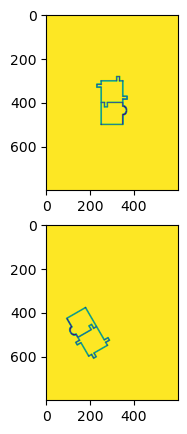

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
f, axarr = plt.subplots(2, figsize=(5, 5))
axarr[0].imshow(scene_list[0])
axarr[1].imshow(scene_list[5])
# axarr[2].imshow(scene_list[2])
# axarr[3].imshow(scene_list[3])
# axarr[4].imshow(scene_list[4])

In [5]:
identical_index = PCA_method(scene_list[0], scene_list[3])
print(identical_index)
print(len(scene_list))

img1 and img2 are identic.
True
4100


In [6]:
# Generate test pairs for evaluation
TP = FP = TN = FN = 0

# Total number of unique scenes (each with 20 variations)
num_scenes = number_scenes
variations_per_scene = number_of_variations

# Evaluate True Positives and False Negatives by comparing each scene with its variations
for i in range(num_scenes):
    original_index = i * (variations_per_scene + 1)
    original = scene_list[original_index]
    for j in range(1, variations_per_scene + 1):
        variation_index = original_index + j
        variation = scene_list[variation_index]
        if PCA_method(original, variation):
            TP += 1
        else:
            FN += 1

# Evaluate True Negatives and False Positives by comparing different scenes
for _ in range(num_scenes*variations_per_scene):  # Arbitrary number of random checks
    idx1, idx2 = rd.sample(range(len(scene_list)), 2)
    # Ensure that idx1 and idx2 are not from the same scene group
    if idx1 // (variations_per_scene + 1) == idx2 // (variations_per_scene + 1):
        continue
    if PCA_method(scene_list[idx1], scene_list[idx2]):
        FP += 1
    else:
        TN += 1

# Calculate rates
total_tests = TP + FP + TN + FN
TPR = TP / (TP + FN) if TP + FN > 0 else 0
TNR = TN / (TN + FP) if TN + FP > 0 else 0
FPR = FP / (FP + TN) if FP + TN > 0 else 0
FNR = FN / (TP + FN) if TP + FN > 0 else 0

img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
i

In [12]:
print(TPR,TNR,FPR,FNR)

0.9585 0.9515151515151515 0.048484848484848485 0.0415


### Fillin with black

In [13]:
# Create a list to hold the images and a set to track unique hashes
scene_list = []
seen_hashes = set()

number_scenes = 100
number_of_variations = 40

while len(scene_list) < number_scenes* (number_of_variations + 1):
    while True:
        scene = generateScene()  # Generate a scene
        kernel = np.ones((5,5),np.uint8)
        scene = cv2.erode(scene, kernel, iterations=1)
        scene = fillContour(scene)

        img_hash = generate_hash(scene)  # Create a hash of the generated scene

        if img_hash not in seen_hashes:
            seen_hashes.add(img_hash)  # Add the hash to the set of seen hashes
            scene_list.append(scene)  # Append the unique scene to the list
            # Generate variations of the scene
            for _ in range(number_of_variations):
                variation = rotate(scene, randint(0, 360))
                variation = translate(variation, randint(-150, 150), randint(-150, 150))
                scene_list.append(variation)  # Append each variation to the list
            break  # Exit the inner loop since a unique image and its variations were generated

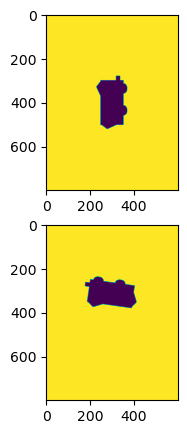

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
f, axarr = plt.subplots(2, figsize=(5, 5))
axarr[0].imshow(scene_list[0])
axarr[1].imshow(scene_list[3])

In [20]:
identical_index_1 = PCA_method(scene_list[0], scene_list[3])
identical_index_2 = PCA_method(scene_list[0], scene_list[30])
print(identical_index_1)
print(identical_index_2)
print(len(scene_list))

img1 and img2 are identic.
img1 and img2 are not identic.
True
False
4100


In [21]:
# Generate test pairs for evaluation
TP = FP = TN = FN = 0

# Total number of unique scenes (each with 20 variations)
num_scenes = number_scenes
variations_per_scene = number_of_variations

# Evaluate True Positives and False Negatives by comparing each scene with its variations
for i in range(num_scenes):
    original_index = i * (variations_per_scene + 1)
    original = scene_list[original_index]
    for j in range(1, variations_per_scene + 1):
        variation_index = original_index + j
        variation = scene_list[variation_index]
        if PCA_method(original, variation):
            TP += 1
        else:
            FN += 1

# Evaluate True Negatives and False Positives by comparing different scenes
for _ in range(num_scenes*variations_per_scene):  # Arbitrary number of random checks
    idx1, idx2 = rd.sample(range(len(scene_list)), 2)
    # Ensure that idx1 and idx2 are not from the same scene group
    if idx1 // (variations_per_scene + 1) == idx2 // (variations_per_scene + 1):
        continue
    if PCA_method(scene_list[idx1], scene_list[idx2]):
        FP += 1
    else:
        TN += 1

# Calculate rates
total_tests = TP + FP + TN + FN
TPR = TP / (TP + FN) if TP + FN > 0 else 0
TNR = TN / (TN + FP) if TN + FP > 0 else 0
FPR = FP / (FP + TN) if FP + TN > 0 else 0
FNR = FN / (TP + FN) if TP + FN > 0 else 0

img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
img1 and img2 are identic.
i

In [22]:
print(TPR,TNR,FPR,FNR)

1.0 0.9989878542510121 0.0010121457489878543 0.0
